In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import os
import collections
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import datasets
from torch.utils.data import Dataset
import torchvision
from tqdm import tqdm
from torch import nn
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights

In [36]:
def count_files_in_drive(folder_file_count: dict, zoom: int, DRIVE_PATH: str):
  '''Function that returns number of files in drive path'''

  for root, dirs, files in os.walk(DRIVE_PATH):
    count = 0
    folder_name = os.path.basename(root)

    for file in files:
      filename = folder_name+'_'+str(zoom)

      if file.startswith(filename) & file.endswith('.jpg'):
          count += 1

    if folder_name.startswith('A'):
      folder_file_count[filename] = count

  return folder_file_count

In [37]:
DRIVE_PATH = '/content/drive/MyDrive/Pianki'

In [38]:
folder_file_count = {}
zooms = [40, 50, 100, 250, 500, 1000] #different microscope maginification
for zoom in zooms:
  folder_file_count = count_files_in_drive(folder_file_count, zoom, DRIVE_PATH)

In [39]:
folder_file_count = collections.OrderedDict(sorted(folder_file_count.items()))
folder_file_count

OrderedDict([('AS10_100', 4),
             ('AS10_1000', 2),
             ('AS10_250', 5),
             ('AS10_40', 35),
             ('AS10_50', 4),
             ('AS10_500', 2),
             ('AS11_100', 4),
             ('AS11_1000', 2),
             ('AS11_250', 4),
             ('AS11_40', 25),
             ('AS11_50', 4),
             ('AS11_500', 2),
             ('AS12_100', 6),
             ('AS12_1000', 3),
             ('AS12_250', 4),
             ('AS12_40', 31),
             ('AS12_50', 6),
             ('AS12_500', 3),
             ('AS13_100', 4),
             ('AS13_1000', 2),
             ('AS13_250', 4),
             ('AS13_40', 21),
             ('AS13_50', 4),
             ('AS13_500', 2),
             ('AS14_100', 4),
             ('AS14_1000', 2),
             ('AS14_250', 4),
             ('AS14_40', 24),
             ('AS14_50', 4),
             ('AS14_500', 2),
             ('AS15_100', 4),
             ('AS15_1000', 2),
             ('AS15_250', 4),
         

In [40]:
sum(folder_file_count.values())

1273

##. Creating dataset

In [41]:
def create_dataset(PATH: str, data: pd.DataFrame, output_property: str):
  '''This function creates dataset - each sample with different magnifications is
      connected with chosen property'''
      
  image_paths = []
  properties = []
  samples = []
  for root, dirs, files in os.walk(PATH):
    for file in files:
      if file.endswith('.jpg'):
        image_path = os.path.join(root, file)
        folder_name = os.path.basename(os.path.dirname(image_path))
        try:
          property_values = data.loc[data['sample_name'] == folder_name, output_property].values[0]
          properties.append(property_values)
          image_paths.append(image_path)
          samples.append(folder_name)
        except IndexError: 
          continue

  df = pd.DataFrame({
      'image_path': image_paths,
      output_property: properties,
      'sample': samples
  })

  return df

In [42]:
def print_random_image(dataset: pd.DataFrame):
  image_path_list = list(dataset['image_path'])

  random_number = random.randint(0, dataset.shape[0])
  random_image_path, random_property = dataset.loc[random_number][0], dataset.loc[random_number][1]
  random_property_name = dataset.columns[1]
  random_sample_name = dataset.loc[random_number][2]

  img = Image.open(random_image_path)

  print(f'Random image path: {random_image_path}')
  print(f'Sample: {random_sample_name}')
  print(f'Property({random_property_name}): {random_property}')
  print(f'Image height: {img.height}')
  print(f'Image width: {img.width}')
  img.show()

In [43]:
data = pd.read_excel('/content/drive/MyDrive/Pianki/Dataset.xlsx', sheet_name='Arkusz2')

In [44]:
data.drop('sample_index', axis=1, inplace=True)

In [45]:
data

,sample_name,SAG,40%_tension,pHRR,T_2%,U600,start_time,expansion_time,gel_time,OP550,EG290,APP422,APP435,LIG_C120,MELAMINA,ATH,EGN30
0,AS1A,2.58,2.58,kW/m2,234,4.1,12,257,570,0,0,0,0,0,0,0,0
1,AS2,2.50,2.32,154,193,3.5,17,320,500,10,0,0,0,0,0,0,0
2,AS3,2.66,2.66,165,228,7.4,10,410,510,0,10,0,0,0,0,0,0
3,AS4,2.88,2.88,109,225,10.4,9,410,740,0,20,0,0,0,0,0,0
4,AS5,3.07,3.07,74,222,13.2,12,380,450,0,30,0,0,0,0,0,0
5,AS6,3.24,3.24,65,202,12.5,12,400,450,10,20,0,0,0,0,0,0
6,AS7,3.45,3.45,91,202,15.3,12,400,430,10,30,0,0,0,0,0,0
7,AS15,2.42,2.42,72,229,8.5,12,330,600,0,0,10,0,0,0,0,0
8,AS16,2.99,2.99,133,222,14.5,13,440,660,0,20,10,0,0,0,0,0
9,AS17,3.16,3.16,78,221,18.6,13,460,720,0,30,10,0,0,0,0,0


In [46]:
dataset = create_dataset('/content/drive/MyDrive/Pianki', data, '40%_tension') #it is commonly known that mechanical properties are related with microstructure, so here I've chosen 40%_tension BUT 
# I've also tested SAG factor (resulting mechanical properties), pHRR and U600 (thermal properties)

In [47]:
dataset

,image_path,40%_tension,sample
0,/content/drive/MyDrive/Pianki/AS6/AS6_2500_1.jpg,3.24,AS6
1,/content/drive/MyDrive/Pianki/AS6/AS6_1000_1.jpg,3.24,AS6
2,/content/drive/MyDrive/Pianki/AS6/AS6_500_1.jpg,3.24,AS6
3,/content/drive/MyDrive/Pianki/AS6/AS6_250_1.jpg,3.24,AS6
4,/content/drive/MyDrive/Pianki/AS6/AS6_100_1.jpg,3.24,AS6
...,...,...,...
767,/content/drive/MyDrive/Pianki/AS1A/AS1A_40_33.jpg,2.58,AS1A
768,/content/drive/MyDrive/Pianki/AS1A/AS1A_40_34.jpg,2.58,AS1A
769,/content/drive/MyDrive/Pianki/AS1A/AS1A_40_35.jpg,2.58,AS1A
770,/content/drive/MyDrive/Pianki/AS1A/AS1A_40_36.jpg,2.58,AS1A


In [48]:
def split_dataset(dataset: pd.DataFrame, TEST_SIZE=0.2,  RANDOM_STATE=42):
  X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:, 0], dataset.iloc[:, 1], test_size=TEST_SIZE, stratify=dataset.iloc[:, 2], random_state=RANDOM_STATE)
  return X_train.reset_index(drop=True),  X_test.reset_index(drop=True),  y_train.reset_index(drop=True),  y_train.reset_index(drop=True)

Random image path: /content/drive/MyDrive/Pianki/AS18/AS18_40_19.jpg
Sample: AS18
Property(40%_tension): 2.34
Image height: 1040
Image width: 1280


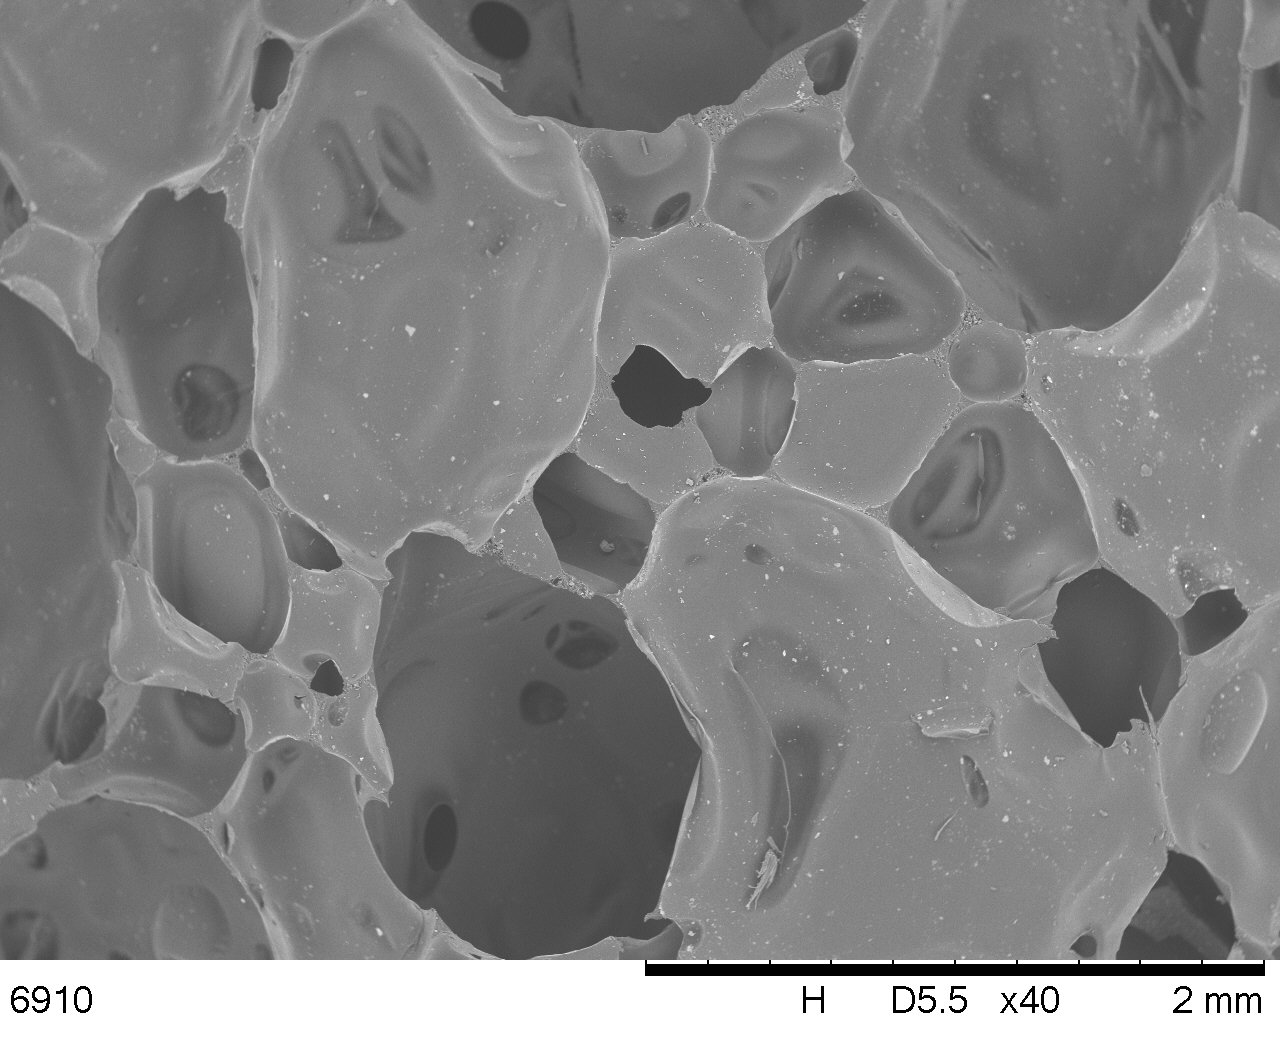

In [49]:
print_random_image(dataset)

In [50]:
X_train, X_test, y_train, y_test = split_dataset(dataset)

## 3. Transforming images to tensors

In [51]:
def show_transformed_images(image_paths, transform, n=3, seed=42):
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original \nSize: {f.size}')
      ax[0].axis('off')

      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed \nSize: {transformed_image.shape}')
      ax[1].axis('off')

In [52]:
def display_random_iamges(dataset: torch.utils.data.dataset.Dataset,
                          n: int = 5,
                          display_shape: bool = True,
                          seed: int = None):
  if n > 10:
    display_shape = False
    n = 10
    print(f'n shouldt be larger than 10')

  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16, 12))

  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    targ_image_adjust = targ_image.permute(1, 2, 0)

    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis('off')
    title = f'Property value: {targ_label}'
    if display_shape:
      title = title + f'\nshape: {list(targ_image_adjust.shape)}'
    plt.title(title)

In [53]:
data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #normalization as used in ResNet training
])

In [54]:
class CustomImageDataset(torch.utils.data.Dataset):
  def __init__(self, X_train, y_train, transform=None):
    self.img_label = y_train
    self.img_path = X_train
    self.transform = transform

  def __len__(self):
    return len(self.img_path)

  def __getitem__(self, idx):
    img_path = self.img_path.iloc[idx]
    image = Image.open(img_path)
    if self.transform:
      image = self.transform(image)
    label = self.img_label.iloc[idx]
    return image, label

In [55]:
train_data = CustomImageDataset(X_train, y_train, transform=data_transform)
test_data = CustomImageDataset(X_test, y_test, transform=data_transform)

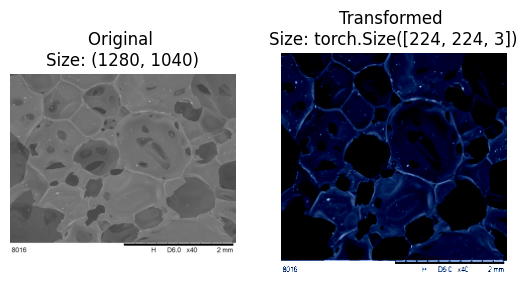

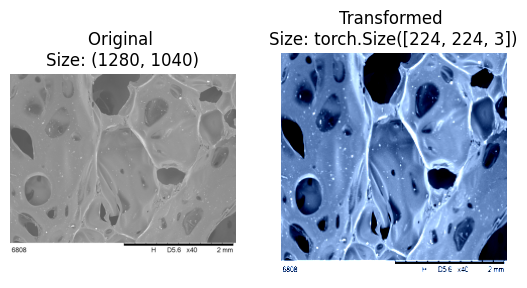

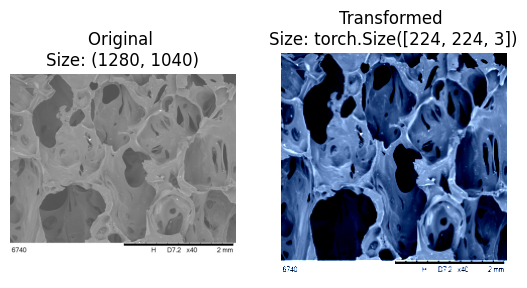

In [56]:
show_transformed_images(list(X_train), transform=data_transform) #Original image vs transformed 

In [57]:
#Organize our data into batches and make them iterable
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=64,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=64,
                             num_workers=1,
                             shuffle=False)

In [58]:
img, label = next(iter(train_dataloader))
print(f'Image shape: {img.shape}')
print(f'Label: {label}')

Image shape: torch.Size([64, 3, 224, 224])
Label: tensor([2.5800, 3.1600, 2.4200, 2.6600, 1.7800, 2.3200, 2.3200, 2.1900, 2.3200,
        3.7800, 3.6800, 2.3400, 3.1600, 2.3200, 2.4200, 2.4200, 3.1600, 2.5800,
        2.3400, 3.7800, 3.4500, 1.7800, 2.7300, 2.6600, 2.6300, 2.6600, 2.8800,
        2.5800, 3.0700, 3.1600, 3.7800, 2.4200, 2.1900, 2.5800, 2.5800, 2.8800,
        2.3200, 2.9900, 3.4500, 2.4200, 3.1600, 3.1600, 3.4000, 3.6800, 3.1600,
        2.3400, 2.9900, 3.4500, 3.4000, 3.7800, 2.6600, 3.0700, 2.3200, 2.8800,
        3.0700, 3.6800, 3.2400, 2.9900, 2.4200, 2.1900, 2.6300, 2.6300, 2.7300,
        3.1600], dtype=torch.float64)


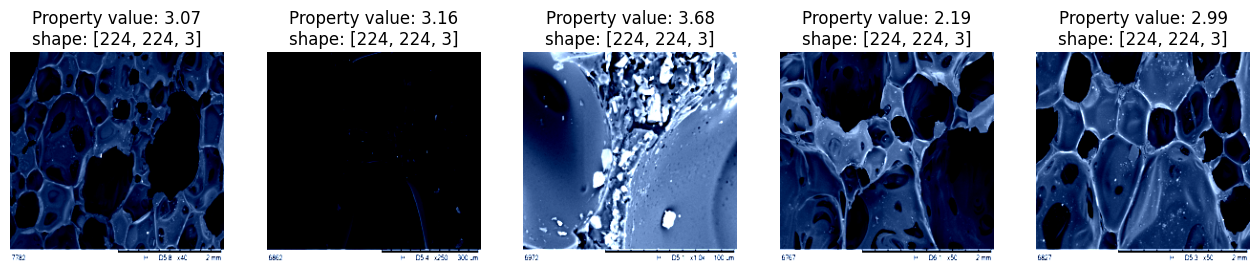

In [59]:
display_random_iamges(train_data) #randomly selected images from dataset and their properties

## Train and test loop

In [60]:
def train_step(model: torch.nn.Module,
               train_dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  train_loss, train_metric = 0, 0
  train_loss_list = []

  model.to(device)
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.float().to(device), y.float().to(device)
    
    #Forward pass
    y_pred = model(X)
    y_pred = y_pred.view(y.shape)

    #Calculate loss
    loss = loss_fn(y_pred, y.squeeze())
    train_loss += loss.item()

    #Optimizer zero grad
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss /= len(train_dataloader)

  print(f'Train loss: {train_loss:.5f}')

  return train_loss

In [61]:
def test_step(model: torch.nn.Module,
              test_dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
  test_loss, test_metric = 0, 0
  test_loss_list = []

  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      X, y = X.float().to(device), y.float().to(device)

      test_pred = model(X)
      test_pred = test_pred.view(y.shape)

      test_loss += loss_fn(test_pred, y.squeeze()).item()

    test_loss /= len(test_dataloader)

    print(f'Test loss: {test_loss:.5f}')
    
    return test_loss

In [62]:
def train_and_test(model: torch.nn.Module,
               train_dataloader: torch.utils.data.DataLoader,
               test_dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: str,
               device: torch.device,
               save_model_name: str,
               learning_rate: int = 0.1,
               epochs: int = 5,
               patience: int = 3):
  
  '''Args:
      optimizer: str - Possible SGD or Adam
  '''

  if optimizer == 'SGD': 
    optimizer = torch.optim.SGD(params=model.parameters(),
                              lr=learning_rate)
  elif optimizer == 'Adam':
    optimizer = torch.optim.Adam(params=model.parameters(),
                              lr=learning_rate)

  train_loss_list, val_loss_list = [], []

  #early stopping
  n_epochs_stop = patience
  min_val_loss = np.inf
  epochs_no_imporve = 0

  for epoch in tqdm(range(epochs)):
    train_loss = train_step(model = model,
               train_dataloader = train_dataloader,
               loss_fn = loss_fn,
               optimizer = optimizer,
               device = device)
    train_loss_list.append(train_loss)

    val_loss = test_step(model = model,
              test_dataloader = test_dataloader,
              loss_fn = loss_fn,
              device = device)
    val_loss_list.append(val_loss)
    
    if val_loss < min_val_loss:
      torch.save(model.state_dict(), save_model_name)
      epochs_no_improve = 0
      min_val_loss = val_loss

    else:
      epochs_no_improve += 1

      if epochs_no_improve == n_epochs_stop:
        print('Early stopping!')
        model.load_state_dict(torch.load(save_model_name))
        epoch_counter = epoch+1
        break
  return train_loss_list, val_loss_list, epoch_counter

In [63]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' #device agnostic code

## ResNet architecture

In [64]:
def plot_train_vs_pred(model: torch.nn.Module,
                       test_dataloader: torch.utils.data.DataLoader,
                       device: str):
  model.eval()
  model.to(device)
  true_vals, pred_vals = [], []

  with torch.inference_mode():
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)

      true_vals.append(y.detach().cpu().numpy())
      pred_vals.append(pred.detach().cpu().numpy())

  true_vals = np.concatenate(true_vals, axis=0)
  pred_vals = np.concatenate(pred_vals, axis=0)

  plt.figure(figsize=(10, 8))

  plt.scatter(true_vals, pred_vals, alpha=0.5)
  plt.xlabel('True values')
  plt.ylabel('Predicted Values')
  plt.title('True vs predicted values')

  #perfect fit
  min_val = min(min(true_vals), min(pred_vals))
  max_val = max(max(true_vals), max(pred_vals))
  plt.plot([min_val, max_val], [min_val, max_val], color='red')

  plt.grid()
  plt.show()

In [65]:
def learning_curve(epoch: int,
                   train_loss: float,
                   test_loss: float):
  
  plt.figure(figsize=(15, 7))


  plt.subplot(1, 2, 1)
  plt.plot(range(epoch), train_loss, label='train_loss')
  plt.plot(range(epoch), test_loss, label='test_loss')
  plt.title('Loss - original shape')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(range(2, epoch), train_loss[2:], label='train_loss')
  plt.plot(range(2, epoch), test_loss[2:], label='test_loss')
  plt.title(f'Loss - from epoch 2')
  plt.xlabel('Epochs')
  plt.legend()

In [66]:
loss_fn = nn.MSELoss() #loss function

In [67]:
#Organize our data into batches and make them iterable
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=4, #I've tested many values here
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=4, #I've tested many values here
                             num_workers=1,
                             shuffle=False)

In [80]:
resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 1) #adjusting model to my output, regression problem

In [81]:
train_loss_resnet50, val_loss_resnet50, epochs_resnet50 = train_and_test(model = resnet50,
               train_dataloader = train_dataloader,
               test_dataloader = test_dataloader,
               loss_fn = loss_fn,
               optimizer = 'Adam', #Hyperparamters - many values tested
               device = device,
               save_model_name = 'model_pianki_0',
               learning_rate = 0.001,
               epochs = 20)

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.22373


  5%|▌         | 1/20 [00:20<06:30, 20.58s/it]

Test loss: 0.60133
Train loss: 5.80047
Test loss: 0.22693


 10%|█         | 2/20 [00:41<06:09, 20.54s/it]

Train loss: 0.32496


 15%|█▌        | 3/20 [01:00<05:39, 19.97s/it]

Test loss: 0.23717
Train loss: 0.28457


 20%|██        | 4/20 [01:20<05:18, 19.93s/it]

Test loss: 0.22615
Train loss: 0.27464


 25%|██▌       | 5/20 [01:39<04:56, 19.77s/it]

Test loss: 0.22615
Train loss: 0.28085


 30%|███       | 6/20 [01:58<04:33, 19.54s/it]

Test loss: 0.22793
Train loss: 0.26879


 30%|███       | 6/20 [02:18<05:22, 23.04s/it]

Test loss: 0.25040
Early stopping!


In [82]:
model_resnet50 = models.resnet50()
num_ftrs = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_ftrs, 1) 
model_resnet50.load_state_dict(torch.load('/content/model_pianki_0'))

<All keys matched successfully>

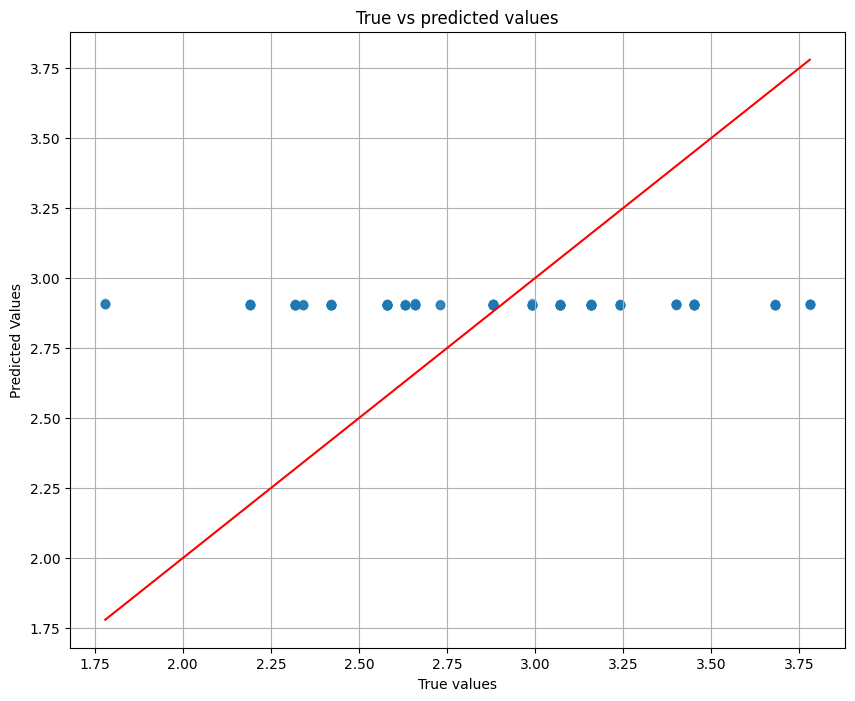

In [83]:
plot_train_vs_pred(model=model_resnet50,
                   test_dataloader = test_dataloader,
                   device=device)

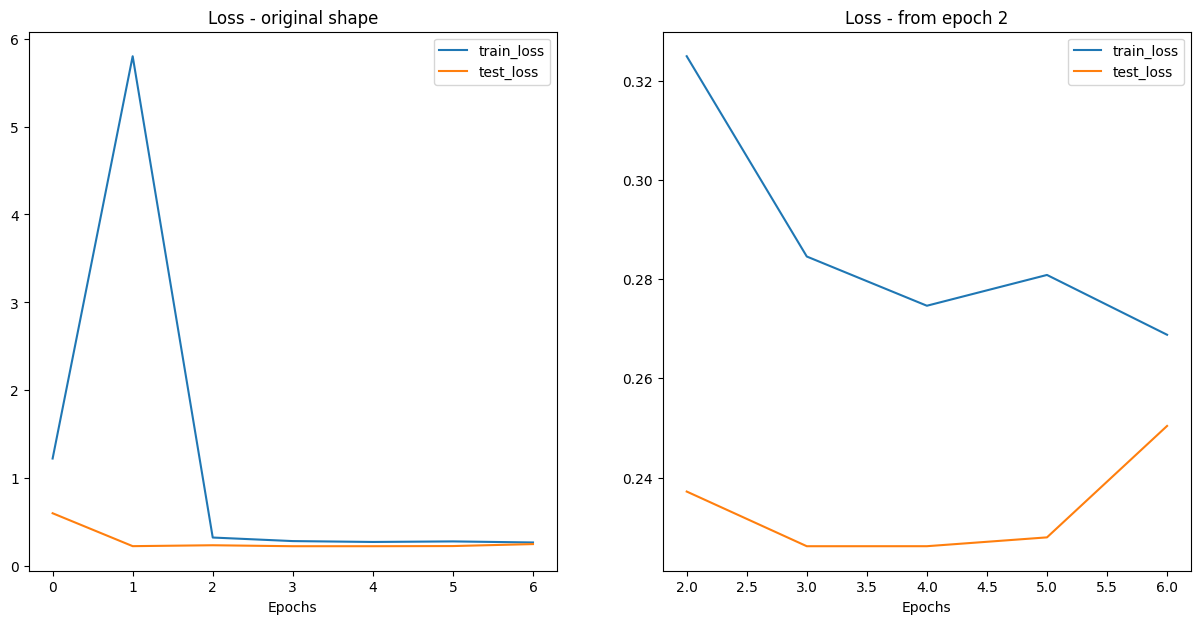

In [84]:
learning_curve(epochs_resnet50,
               train_loss_resnet50,
               val_loss_resnet50)

# With Data Augmentation

In [85]:
loss_fn = nn.MSELoss()

In [86]:
resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 1) #adjusting model to my output

In [87]:
data_transform_augmentation = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [88]:
train_data = CustomImageDataset(X_train, y_train, transform=data_transform_augmentation)
test_data = CustomImageDataset(X_test, y_test, transform=data_transform)

In [89]:
#Organize our data into batches and make them iterable
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             num_workers=1,
                             shuffle=False)

In [90]:
train_loss_resnet50_aug, val_loss_resnet50_aug, epochs_resnet50_aug = train_and_test(model = resnet50,
               train_dataloader = train_dataloader,
               test_dataloader = test_dataloader,
               loss_fn = loss_fn,
               optimizer = 'Adam',
               device = device,
               save_model_name = 'model_pianki_augmentacja',
               learning_rate = 0.0001,
               epochs  = 20)

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.35366
Test loss: 2.53817


  5%|▌         | 1/20 [00:20<06:25, 20.28s/it]

Train loss: 0.56297
Test loss: 0.28118


 10%|█         | 2/20 [00:39<05:58, 19.91s/it]

Train loss: 0.31452
Test loss: 0.26667


 15%|█▌        | 3/20 [00:59<05:37, 19.88s/it]

Train loss: 0.27864
Test loss: 0.26551


 20%|██        | 4/20 [01:20<05:23, 20.20s/it]

Train loss: 0.24597


 25%|██▌       | 5/20 [01:40<05:01, 20.11s/it]

Test loss: 0.30112
Train loss: 0.24521


 30%|███       | 6/20 [02:00<04:41, 20.10s/it]

Test loss: 0.30871
Train loss: 0.21880


 30%|███       | 6/20 [02:20<05:28, 23.45s/it]

Test loss: 0.32322
Early stopping!


In [91]:
model_resnet50_aug = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = model_resnet50_aug.fc.in_features
model_resnet50_aug.fc = nn.Linear(num_ftrs, 1)
model_resnet50_aug.load_state_dict(torch.load('/content/model_pianki_augmentacja'))

<All keys matched successfully>

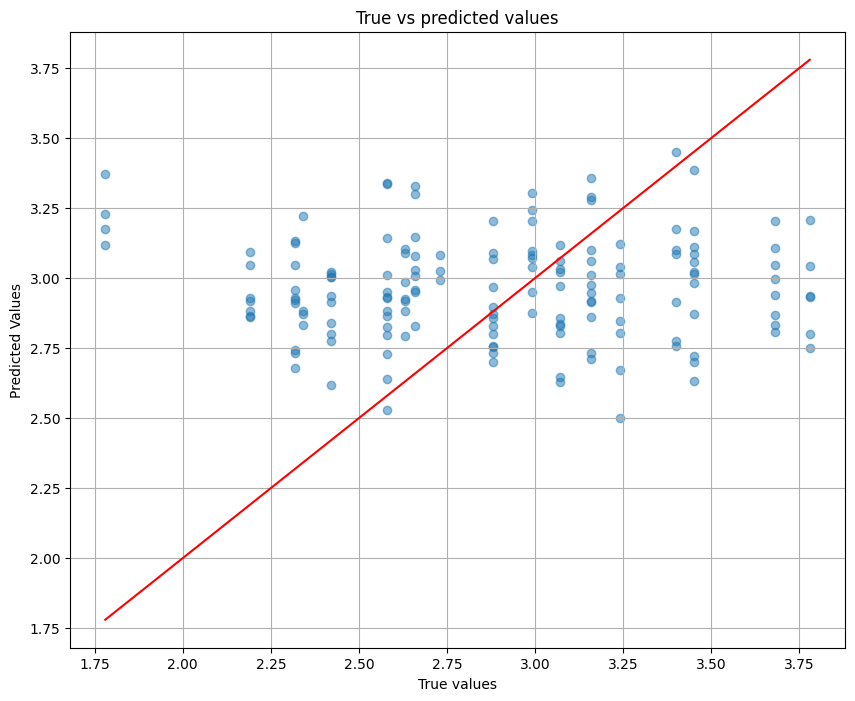

In [92]:
plot_train_vs_pred(model_resnet50_aug,
                   test_dataloader,
                   device)

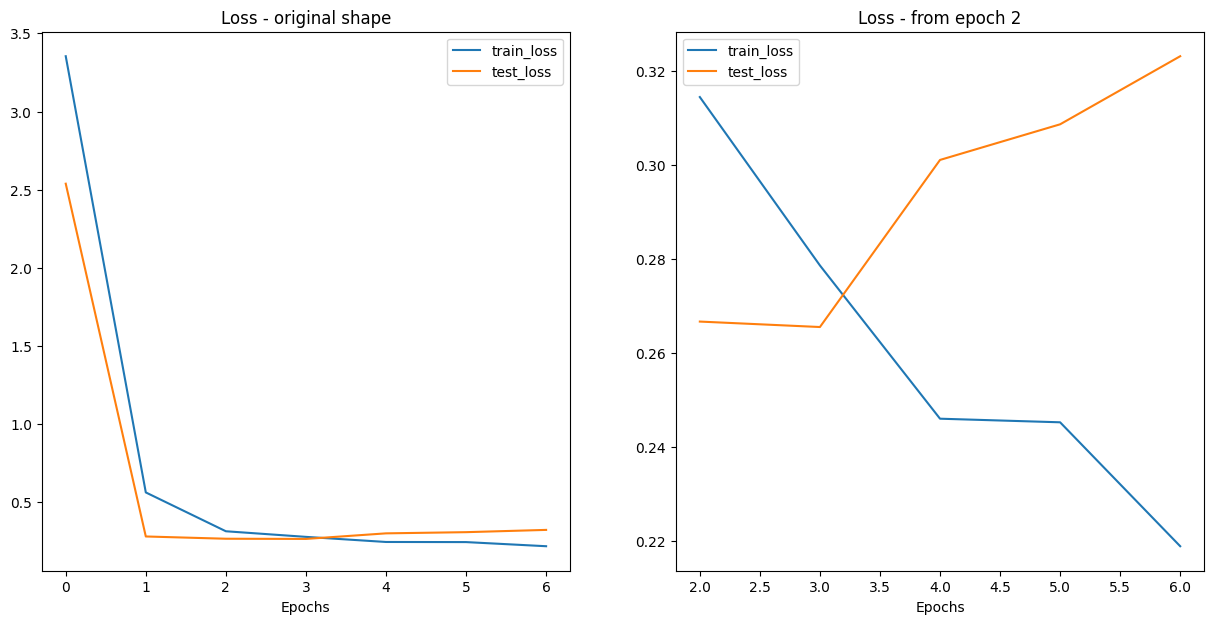

In [93]:
learning_curve(epochs_resnet50_aug, 
               train_loss_resnet50_aug, 
               val_loss_resnet50_aug)

## Test another loss functions

In [94]:
def train_step(model: torch.nn.Module,
               train_dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  train_loss, train_metric = 0, 0
  train_loss_list = []

  model.to(device)
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.float().to(device), y.float().to(device)
    
    #Forward pass
    y_pred = model(X)
    y_pred = y_pred.view(y.shape)

    #Calculate loss
    loss = loss_fn(y_pred.view(-1), y.view(-1))
    train_loss += loss.item()

    #Optimizer zero grad
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss /= len(train_dataloader)

  print(f'Train loss: {train_loss:.5f}')

  return train_loss

In [95]:
def test_step(model: torch.nn.Module,
              test_dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
  test_loss, test_metric = 0, 0
  test_loss_list = []

  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      X, y = X.float().to(device), y.float().to(device)

      test_pred = model(X)
      test_pred = test_pred.view(y.shape)

      loss = loss_fn(test_pred.view(-1), y.view(-1))
      test_loss += loss.item()  # Here is the change

    test_loss /= len(test_dataloader)

    print(f'Test loss: {test_loss:.5f}')
    
    return test_loss

In [96]:
def train_and_test(model: torch.nn.Module,
               train_dataloader: torch.utils.data.DataLoader,
               test_dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: str,
               device: torch.device,
               save_model_name: str,
               learning_rate: int = 0.1,
               epochs: int = 5,
               patience: int = 3):
  
  '''Args:
      optimizer: str - Possible SGD or Adam
  '''

  if optimizer == 'SGD': 
    optimizer = torch.optim.SGD(params=model.parameters(),
                              lr=learning_rate)
  elif optimizer == 'Adam':
    optimizer = torch.optim.Adam(params=model.parameters(),
                              lr=learning_rate)
  elif optimizer == 'RMSprop':
    optimizer = torch.optim.RMSprop(params=model.parameters(),
                              lr=learning_rate)

  train_loss_list, val_loss_list = [], []

  #early stopping
  n_epochs_stop = patience
  min_val_loss = np.inf
  epochs_no_imporve = 0

  for epoch in tqdm(range(epochs)):
    train_loss = train_step(model = model,
               train_dataloader = train_dataloader,
               loss_fn = loss_fn,
               optimizer = optimizer,
               device = device)
    train_loss_list.append(train_loss)

    val_loss = test_step(model = model,
              test_dataloader = test_dataloader,
              loss_fn = loss_fn,
              device = device)
    val_loss_list.append(val_loss)
    
    if val_loss < min_val_loss:
      torch.save(model.state_dict(), save_model_name)
      epochs_no_improve = 0
      min_val_loss = val_loss

    else:
      epochs_no_improve += 1

      if epochs_no_improve == n_epochs_stop:
        print('Early stopping!')
        model.load_state_dict(torch.load(save_model_name))
        epoch_counter = epoch+1
        break
  return train_loss_list, val_loss_list, epoch_counter

In [97]:
loss_fn = nn.SmoothL1Loss()

In [98]:
#Organize our data into batches and make them iterable
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=8,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=8,
                             num_workers=1,
                             shuffle=False)

In [99]:
resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 1) #adjusting model to my output

In [100]:
train_loss_resnet50, val_loss_resnet50, epochs_resnet50 = train_and_test(model = resnet50,
               train_dataloader = train_dataloader,
               test_dataloader = test_dataloader,
               loss_fn = loss_fn,
               optimizer = 'RMSprop',
               device = device,
               save_model_name = 'model_pianki_SmoothL1Loss',
               learning_rate = 0.0001,
               epochs = 20)

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 0.28313


  5%|▌         | 1/20 [00:21<06:48, 21.52s/it]

Test loss: 0.24632
Train loss: 0.75442
Test loss: 0.12602


 10%|█         | 2/20 [00:42<06:19, 21.09s/it]

Train loss: 0.13835


 15%|█▌        | 3/20 [01:02<05:52, 20.75s/it]

Test loss: 0.16475
Train loss: 0.13920


 20%|██        | 4/20 [01:22<05:26, 20.41s/it]

Test loss: 0.26633
Train loss: 0.13464


 20%|██        | 4/20 [01:42<06:48, 25.53s/it]

Test loss: 0.23719
Early stopping!


In [101]:
model_resnet50 = models.resnet50()
num_ftrs = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_ftrs, 1)
model_resnet50.load_state_dict(torch.load('/content/model_pianki_SmoothL1Loss'))

<All keys matched successfully>

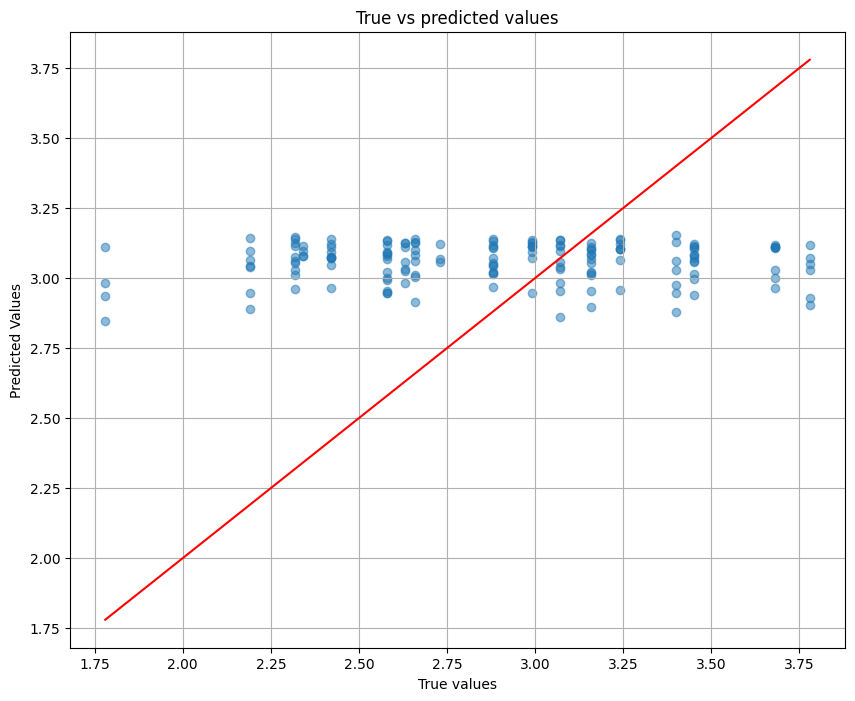

In [102]:
plot_train_vs_pred(model=model_resnet50,
                   test_dataloader = test_dataloader,
                   device=device)

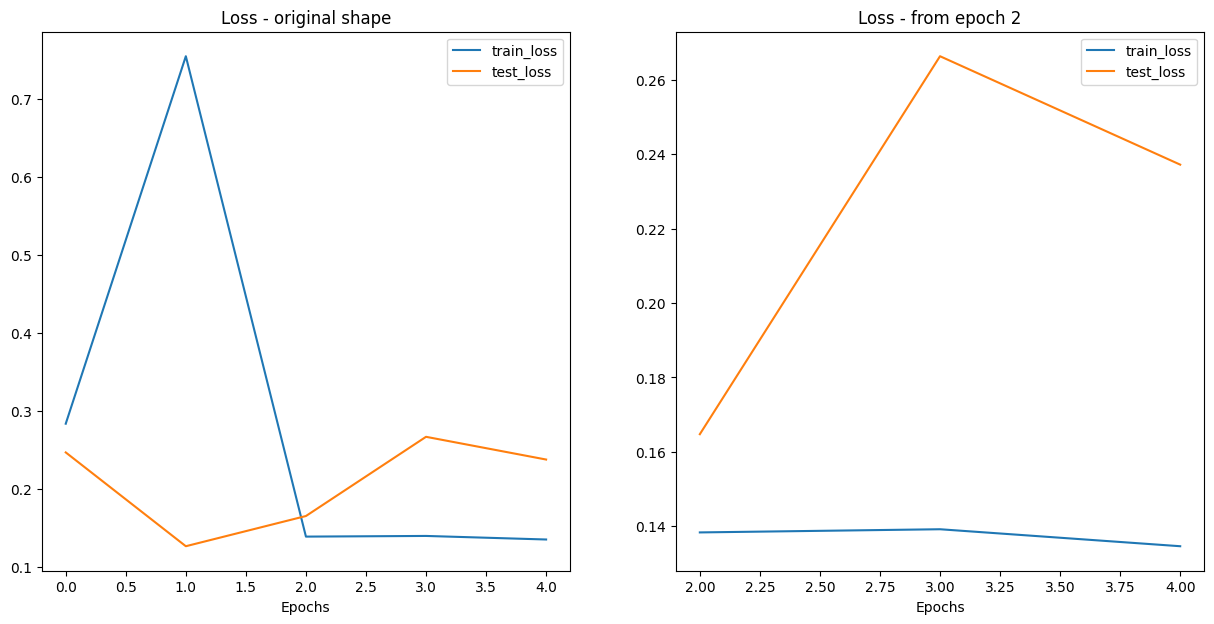

In [103]:
learning_curve(epochs_resnet50,
               train_loss_resnet50,
               val_loss_resnet50)

## Own Neural Network

In [104]:
class SEMNet(nn.Module):

  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) 
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) 
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*53*53,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x

In [ ]:
data_transform_augmentation = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_data = CustomImageDataset(X_train, y_train, transform=data_transform_augmentation)
test_data = CustomImageDataset(X_test, y_test, transform=data_transform)

In [105]:
loss_fn = nn.MSELoss()

In [106]:
#Organize our data into batches and make them iterable
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=64,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=64,
                             num_workers=1,
                             shuffle=False)

In [107]:
model = SEMNet(input_shape=3, hidden_units=48, output_shape=1)

In [108]:
train_loss_nn, val_loss_nn, epochs_nn = train_and_test(model = model,
               train_dataloader = train_dataloader,
               test_dataloader = test_dataloader,
               loss_fn = loss_fn,
               optimizer = 'Adam',
               device = device,
               save_model_name = 'model_pianki_OwnNN',
               learning_rate = 0.00001,
               epochs = 20)

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.85623


  5%|▌         | 1/20 [00:19<06:16, 19.82s/it]

Test loss: 7.62253
Train loss: 6.51436


 10%|█         | 2/20 [00:39<05:57, 19.84s/it]

Test loss: 6.23388
Train loss: 5.05385


 15%|█▌        | 3/20 [00:59<05:38, 19.93s/it]

Test loss: 4.74078
Train loss: 3.59064


 20%|██        | 4/20 [01:20<05:21, 20.08s/it]

Test loss: 3.21367
Train loss: 2.16227


 25%|██▌       | 5/20 [01:39<05:00, 20.02s/it]

Test loss: 1.82464
Train loss: 1.03511


 30%|███       | 6/20 [01:59<04:37, 19.81s/it]

Test loss: 0.83604
Train loss: 0.45145


 35%|███▌      | 7/20 [02:18<04:16, 19.76s/it]

Test loss: 0.41463
Train loss: 0.33825


 40%|████      | 8/20 [02:38<03:56, 19.72s/it]

Test loss: 0.34817
Train loss: 0.35191


 45%|████▌     | 9/20 [02:58<03:36, 19.67s/it]

Test loss: 0.33931
Train loss: 0.32540


 50%|█████     | 10/20 [03:17<03:16, 19.69s/it]

Test loss: 0.35486
Train loss: 0.30871


 55%|█████▌    | 11/20 [03:37<02:56, 19.64s/it]

Test loss: 0.36469
Train loss: 0.30397


 55%|█████▌    | 11/20 [03:57<03:14, 21.56s/it]

Test loss: 0.35220
Early stopping!


In [109]:
model = SEMNet(input_shape=3, hidden_units=48, output_shape=1)
model.load_state_dict(torch.load('/content/model_pianki_OwnNN'))

<All keys matched successfully>

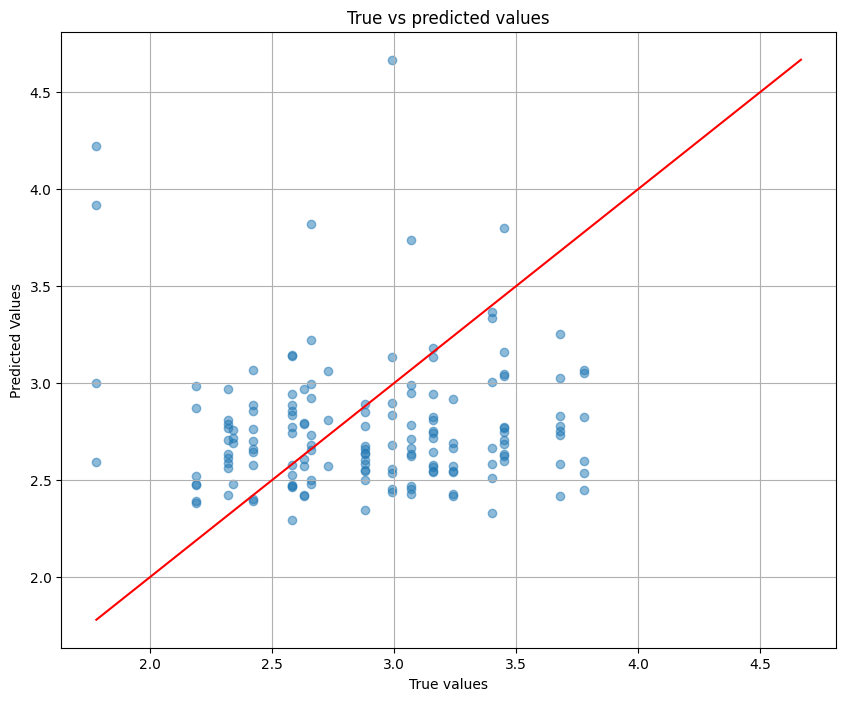

In [110]:
plot_train_vs_pred(model=model,
                   test_dataloader = test_dataloader,
                   device=device)

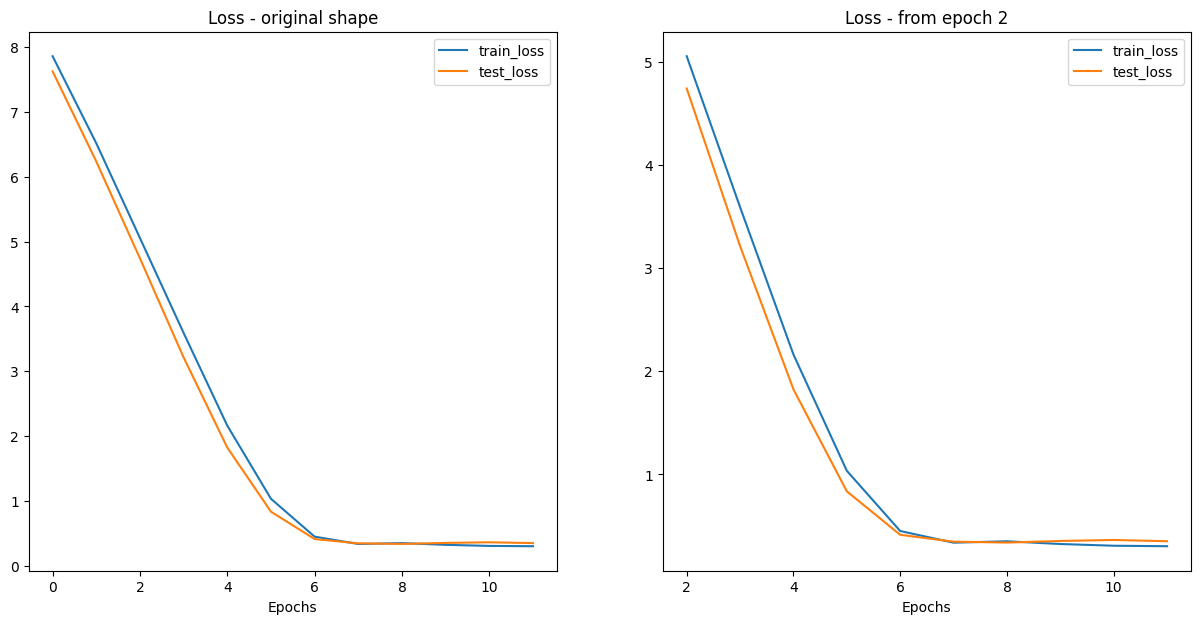

In [111]:
learning_curve(epochs_nn,
               train_loss_nn,
               val_loss_nn)

To solve the problem many attemps have been made. 

* Pretrained models (transfer learning)
  * Resnet34 architecture
  * Resnet 50 
  * EfficientNet

* Own Neural network inspired by TinyVGG
* Data augmentation
* Many different hyperparameters, f.e. batch size, optimizers, loss functions, learning rates, different transforms.

* Own neural network shows the best performance and close is also ResNet50. But model is not good enough. Main problem might be small dataset or complexity of the phenomenon. 